# Import Statements

In [9]:
import logging
logging.basicConfig(level=logging.INFO)
import warnings
warnings.filterwarnings('ignore')

import geodata
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#packages that requires users to install externally
import pickle
import pyproj
from pyproj import Proj
from functools import partial
from shapely.geometry import shape, Point, Polygon, MultiPolygon
from shapely.ops import cascaded_union
from shapely.ops import transform as transform
import statsmodels.api as sm
import cartopy.io.shapereader as shpreader
import geopandas as gpd
import geoplot
import seaborn as sns
import plotly.graph_objects as go

# Load from pickle

In [2]:
# load from pickle before first run
file = open("districts.pickle",'rb')
districts = pickle.load(file)
file.close()

# state shapes
file = open("states.pickle",'rb')
states = pickle.load(file)
file.close()

# includes LCOE
file = open("xarray_ds_wind.pickle",'rb')
xarray_ds_wind = pickle.load(file)
file.close()
file = open("xarray_ds_solar.pickle",'rb')
xarray_ds_solar = pickle.load(file)
file.close()

# renewable energy targets
# TERI
file = open("wind_t_30.pickle",'rb')
wind_t_30 = pickle.load(file)
file.close()
file = open("solar_t_30.pickle",'rb')
solar_t_30 = pickle.load(file)
file.close()

# NREL
file = open("wind_t_47.pickle",'rb')
wind_t_47 = pickle.load(file)
file.close()
file = open("solar_t_47.pickle",'rb')
solar_t_47 = pickle.load(file)
file.close()

# Download India 2018 ERA5 Hourly Weather Data

In [3]:
DS_hourly = geodata.Dataset(module="era5",
                            weather_data_config = "wind_solar_hourly",
                            bounds=[37, 68, 6, 98],
                            years=slice(2018, 2018),
                            months=slice(1,12))

if DS_hourly.prepared == False:
	DS_hourly.get_data()

INFO:geodata.dataset:Directory C:/Users/arjun/desktop/davidson_lab/data/era5 found, checking for completeness.
INFO:geodata.dataset:Directory complete.


# Create Cutout

In [4]:
## CUTOUT
cutout = geodata.Cutout(name = "india-2018-era5-wind-solar-hourly",
                        module = "era5",
                        weather_data_config = "wind_solar_hourly",
                        xs = slice(68, 98),
                        ys = slice(6, 37),
                        years=slice(2018, 2018),
                        months=slice(1,12))

cutout.prepare()

INFO:geodata.cutout:All cutout (india-2018-era5-wind-solar-hourly, C:/Users/arjun/desktop/davidson_lab/data/cutouts) files available.
INFO:geodata.cutout:Cutout subset prepared: <Cutout india-2018-era5-wind-solar-hourly x=68.00-98.00 y=37.00-6.00 time=2018/1-2018/12 prepared>
INFO:geodata.preparation:The cutout is already prepared. If you want to recalculate it, supply an `overwrite=True` argument.


True

# Import Coal Plant / Mine Data

### Importing data from Global Coal Plant Tracker
- July 2020: https://bit.ly/2Cz1Q82
- July 2021 Update: https://bit.ly/3ec60To

In [5]:
plants = pd.read_csv("July 2021 Global Coal Plant Tracker.csv", encoding="ISO-8859-1")
plants = plants[plants['Country'] == 'India']
plants = plants[plants['Latitude'].isna() == False]
plants = plants[plants['Longitude'].isna() == False]
plants = plants[plants['Status'].isin(['operating'])] 
# 'announced', 'cancelled', 'construction', 'permitted', 'pre-permit', 'retired', 'shelved'])]
plants = plants.drop_duplicates('ParentID')
plants = plants[['Plant', 'Subnational unit (province, state)', 'Status', 'Latitude', 'Longitude', 
                 'Capacity (MW)', 'Annual CO2 (million tonnes / annum)', 'Year']]
plants = plants.rename(columns={'Subnational unit (province, state)': 'State', 'Year': 'Plant Age'})
plants['Capacity (MW)'] = plants['Capacity (MW)'].astype(float)
plants['Plant Age'] = plants['Plant Age'].apply(lambda x: 2021 - float(x))
plants

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Plant           State     Status  \
6744          Adani Korba West power station    Chhattisgarh  operating   
6748          Aditya Aluminium power station          Odisha  operating   
6756                     Ajmer power station       Rajasthan  operating   
6758                  Akrimota Power Project         Gujarat  operating   
6764  Ambujanagar Cement Plant power station         Gujarat  operating   
...                                      ...             ...        ...   
8574            Vizag Simhadri power station  Andhra Pradesh  operating   
8575         Vizag Steel Plant power station  Andhra Pradesh  operating   
8580               Vizag Thermal Power Plant  Andhra Pradesh  operating   
8597              Wardha Works power station     Maharashtra  operating   
8622                  Yermarus power station       Karnataka  operating   

       Latitude  Longitude  Capacity (MW)  \
6744  21.743775  83.274093          600.0   
6748  21.740068  84.060592          150.0   
6756  26.073889  74.385000          150.0   
6758  23.772500  68.645556          125.0   
6764  20.835455  70.695539           30.0   
...         ...        ...            ...   
8574  17.636926  83.193133           50.0   
8575  17.606547  83.196713           60.0   
8580  17.563643  83.138877          520.0   
8597  20.460000  79.800000           40.0   
8622  16.295261  77.356120          800.0   

      Annual CO2 (million tonnes / annum)  Plant Age  
6744                                  3.0        7.0  
6748                                  0.7        7.0  
6756                                  0.7       10.0  
6758                                  1.2       14.0  
6764                                  0.2       14.0  
...                                   ...        ...  
8574                                  0.2        9.0  
8575                                  0.3       32.0  
8580                                  2.0        6.0  
8597                                  0.2       22.0  
8622                                  3.0        5.0  

[117 rows x 8 columns]

### Importing data from Global Coal Mine Tracker
- July 2020: https://drive.google.com/file/d/1j0zVllXW6Ei9L2mDiqOonsH9JlQe5DWQ/view?usp=sharing
- July 2021 Update: https://www.dropbox.com/s/yp82wpf3juqe3dk/Global%20Coal%20Mine%20Tracker%20%28June%202021%29.xlsx?dl=0

In [6]:
mines = pd.read_csv("June 2021 Global Coal Mine Tracker.csv", encoding="ISO-8859-1")
mines = mines[mines['Country'] == 'India']
mines = mines[mines['Status'] == 'Operating'] # 'Proposed'
mines = mines[mines['Latitude'].isna() == False]
mines = mines[mines['Longitude'].isna() == False]
mines = mines.drop_duplicates('Mine ID') 
mines = mines[['Mine Name', 'Status', 'Status Detail', 'State, Province', 'Coal Output (Annual, Mt)', 'Mine Type', 
               'Latitude', 'Longitude', 'Opening Year']]
mines = mines[mines['Opening Year'] != 'TBD']
mines['Mine Age'] = mines['Opening Year'].apply(lambda x: 2021 - float(x))
mines = mines.drop(columns=['Opening Year'])
mines

Mine Name     Status  \
9                                    Adriyala Coal Mine  Operating   
17                                        AKK Coal Mine  Operating   
25                                    Amadand Coal Mine  Operating   
26    Amalgamated Keshalpur-West Mudidih (AKWMC) Coa...  Operating   
32                               Amelia North Coal Mine  Operating   
...                                                 ...        ...   
1264                                     Topa Coal Mine  Operating   
1285                                Ukni Deep Coal Mine  Operating   
1290                                  Umarsar Coal Mine  Operating   
1291                                    Umrer Coal Mine  Operating   
1360                              West Bokaro Coal Mine  Operating   

     Status Detail State, Province  Coal Output (Annual, Mt)  \
9              NaN       Telangana                      2.10   
17             NaN       Jharkhand                      4.50   
25             NaN  Madhya Pradesh                      1.60   
26             NaN       Jharkhand                      4.20   
32             NaN  Madhya Pradesh                      2.80   
...            ...             ...                       ...   
1264           NaN       Jharkhand                      1.20   
1285           NaN     Maharashtra                      1.40   
1290           NaN         Gujarat                      1.40   
1291           NaN     Maharashtra                      4.85   
1360           NaN       Jharkhand                      5.30   

                  Mine Type   Latitude  Longitude  Mine Age  
9               Underground  18.664800  79.579000       NaN  
17                  Surface  23.790500  85.919800       NaN  
25                  Surface  23.143600  82.057900       NaN  
26    Underground & Surface  23.807800  86.322100       NaN  
32                  Surface  24.134600  82.426400       NaN  
...                     ...        ...        ...       ...  
1264                Surface  23.737900  85.480700       NaN  
1285                Surface  20.029200  79.054600       NaN  
1290                Surface  23.723770  68.837769       NaN  
1291                Surface  20.845833  79.271666       NaN  
1360                Surface  23.792747  85.554231       NaN  

[133 rows x 9 columns]

## Convert to circular shapes of certain radius

In [10]:
proj_wgs84 = Proj('+proj=longlat +datum=WGS84')

def geodesic_point_buffer(lat, lon, km):
    # Azimuthal equidistant projection
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform,
        Proj(aeqd_proj.format(lat=lat, lon=lon)),
        proj_wgs84)
    buf = Point(0, 0).buffer(km * 1000)  # distance in metres
    return Polygon(transform(project, buf).exterior.coords[:])

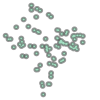

In [11]:
plants['geometry'] = plants.apply(lambda x: geodesic_point_buffer(x['Latitude'], x['Longitude'], 50), axis=1)
plant_states = set(plants['State'])
plant_shapes = cascaded_union(plants['geometry'])
plant_shapes

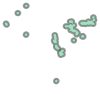

In [12]:
mines['geometry'] = mines.apply(lambda x: geodesic_point_buffer(x['Latitude'], x['Longitude'], 50), axis=1)
mine_states = set(mines['State, Province']) - set(['Madhya Pradesh / Uttar Pradesh', 'Uttar Pradesh / Madhya Pradesh'])
mine_shapes = cascaded_union(mines['geometry'])
mine_shapes

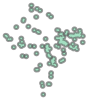

In [13]:
all_states = plant_states.union(mine_states)
all_shapes = cascaded_union(plants['geometry'].append(mines['geometry']))
all_shapes

# Load Geodata MODIS Mask

In [14]:
india_wind_plants = geodata.Mask("India Wind Plants", layer_path = {
    'modis': 'MODIS_INDIA.tif'
})
india_wind_mines = geodata.Mask("India Wind Mines", layer_path = {
    'modis': 'MODIS_INDIA.tif'
})
india_wind_all = geodata.Mask("India Wind All", layer_path = {
    'modis': 'MODIS_INDIA.tif'
})

india_solar_plants = geodata.Mask("India Solar Plants", layer_path = {
    'modis': 'MODIS_INDIA.tif'
})
india_solar_mines = geodata.Mask("India Solar Mines", layer_path = {
    'modis': 'MODIS_INDIA.tif'
})
india_solar_all = geodata.Mask("India Solar All", layer_path = {
    'modis': 'MODIS_INDIA.tif'
})

INFO:geodata.mask:Layer modis added to the mask India Wind Plants.
INFO:geodata.mask:Layer modis added to the mask India Wind Mines.
INFO:geodata.mask:Layer modis added to the mask India Wind All.
INFO:geodata.mask:Layer modis added to the mask India Solar Plants.
INFO:geodata.mask:Layer modis added to the mask India Solar Mines.
INFO:geodata.mask:Layer modis added to the mask India Solar All.


In [15]:
india_wind_plants.layers['modis'] = geodata.mask.binarize_raster(india_wind_plants.layers['modis'], values = [6,7,8,9,10,12,14,16])
india_wind_mines.layers['modis'] = geodata.mask.binarize_raster(india_wind_mines.layers['modis'], values = [6,7,8,9,10,12,14,16])
india_wind_all.layers['modis'] = geodata.mask.binarize_raster(india_wind_all.layers['modis'], values = [6,7,8,9,10,12,14,16])

india_solar_plants.layers['modis'] = geodata.mask.binarize_raster(india_solar_plants.layers['modis'], values = [6,7,8,9,10,16])
india_solar_mines.layers['modis'] = geodata.mask.binarize_raster(india_solar_mines.layers['modis'], values = [6,7,8,9,10,16])
india_solar_all.layers['modis'] = geodata.mask.binarize_raster(india_solar_all.layers['modis'], values = [6,7,8,9,10,16])

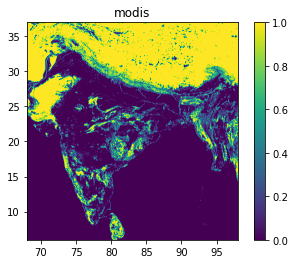

In [16]:
geodata.mask.show_all(india_solar_plants.layers)

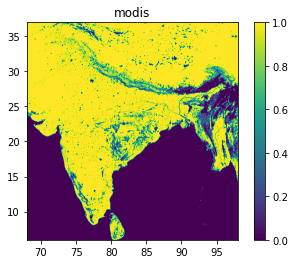

In [17]:
geodata.mask.show_all(india_wind_plants.layers)

# Extract Shapes as Mask Layers

In [18]:
plant_shapes = {'coal': plant_shapes}
mine_shapes = {'coal': mine_shapes}
all_shapes = {'coal': all_shapes}

In [19]:
india_wind_plants.extract_shapes(plant_shapes, layer = 'modis')
india_wind_mines.extract_shapes(mine_shapes, layer = 'modis')
india_wind_all.extract_shapes(all_shapes, layer = 'modis')

india_solar_plants.extract_shapes(plant_shapes, layer = 'modis')
india_solar_mines.extract_shapes(mine_shapes, layer = 'modis')
india_solar_all.extract_shapes(all_shapes, layer = 'modis')

INFO:geodata.mask:Extracted shape coal added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape coal added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape coal added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape coal added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape coal added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape coal added to attribute 'shape_mask'.


In [20]:
india_wind_plants.add_shape_layer({
    'coal': plant_shapes['coal']
}, reference_layer='modis')

india_wind_mines.add_shape_layer({
    'coal': mine_shapes['coal']
}, reference_layer='modis')

india_wind_all.add_shape_layer({
    'coal': all_shapes['coal']
}, reference_layer='modis')


india_solar_plants.add_shape_layer({
    'coal': plant_shapes['coal']
}, reference_layer='modis')

india_solar_mines.add_shape_layer({
    'coal': mine_shapes['coal']
}, reference_layer='modis')

india_solar_all.add_shape_layer({
    'coal': all_shapes['coal']
}, reference_layer='modis')

INFO:geodata.mask:Layer coal added to the mask India Wind Plants.
INFO:geodata.mask:Layer coal added to the mask India Wind Mines.
INFO:geodata.mask:Layer coal added to the mask India Wind All.
INFO:geodata.mask:Layer coal added to the mask India Solar Plants.
INFO:geodata.mask:Layer coal added to the mask India Solar Mines.
INFO:geodata.mask:Layer coal added to the mask India Solar All.


# Merge Districts + MODIS

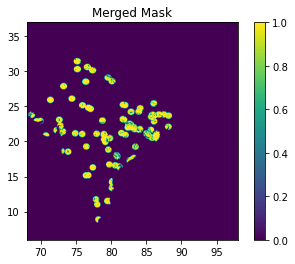

INFO:geodata.mask:Merged Mask saved as attribute 'merged_mask'.


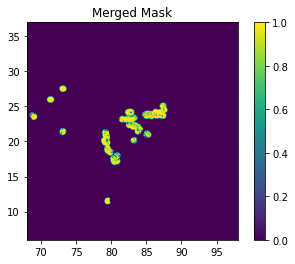

INFO:geodata.mask:Merged Mask saved as attribute 'merged_mask'.


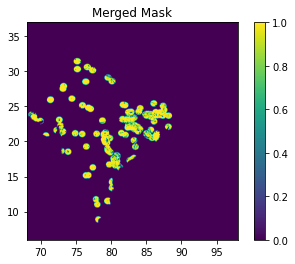

INFO:geodata.mask:Merged Mask saved as attribute 'merged_mask'.


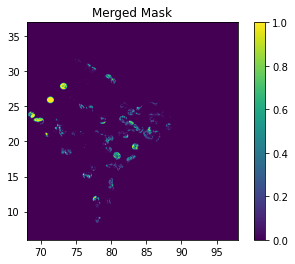

INFO:geodata.mask:Merged Mask saved as attribute 'merged_mask'.


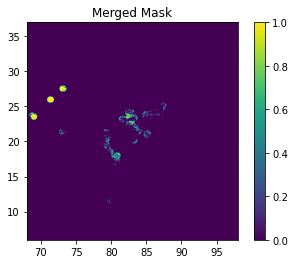

INFO:geodata.mask:Merged Mask saved as attribute 'merged_mask'.


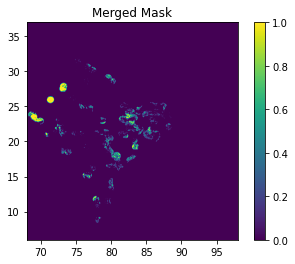

INFO:geodata.mask:Merged Mask saved as attribute 'merged_mask'.


In [21]:
india_wind_plants.merge_layer(attribute_save = True, layers = ['coal', 'modis'], method='and')
india_wind_mines.merge_layer(attribute_save = True, layers = ['coal', 'modis'], method='and')
india_wind_all.merge_layer(attribute_save = True, layers = ['coal', 'modis'], method='and')

india_solar_plants.merge_layer(attribute_save = True, layers = ['coal', 'modis'], method='and')
india_solar_mines.merge_layer(attribute_save = True, layers = ['coal', 'modis'], method='and')
india_solar_all.merge_layer(attribute_save = True, layers = ['coal', 'modis'], method='and')

## States 

In [22]:
india_wind_plants.extract_shapes({x: states[x] for x in plant_states if x in states.keys()})
india_wind_mines.extract_shapes({x: states[x] for x in mine_states if x in states.keys()})
india_wind_all.extract_shapes({x: states[x] for x in all_states if x in states.keys()})

india_solar_plants.extract_shapes({x: states[x] for x in plant_states if x in states.keys()})
india_solar_mines.extract_shapes({x: states[x] for x in mine_states if x in states.keys()})
india_solar_all.extract_shapes({x: states[x] for x in all_states if x in states.keys()})

INFO:geodata.mask:Extracted shape Odisha added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Telangana added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Bihar added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Uttar Pradesh added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Rajasthan added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Chhattisgarh added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Madhya Pradesh added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape West Bengal added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Tamil Nadu added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Uttarakhand added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Haryana added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Gujarat added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Andhra Pradesh added to attribute 's

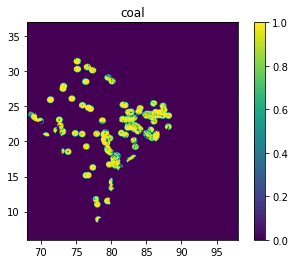

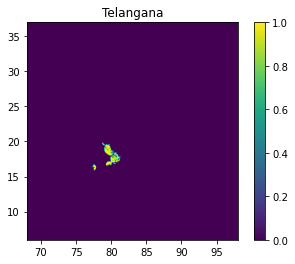

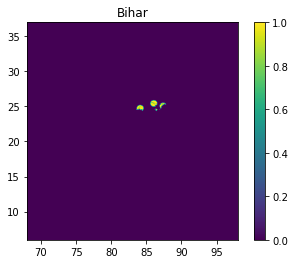

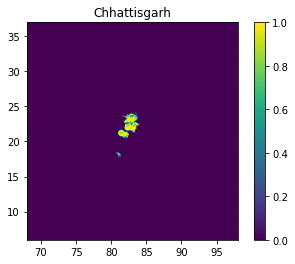

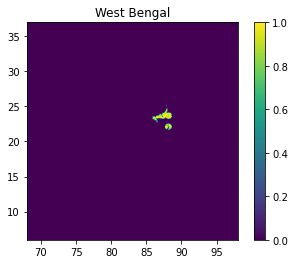

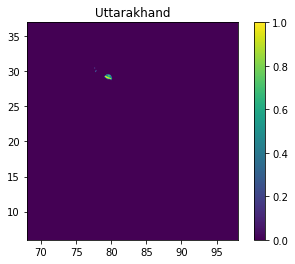

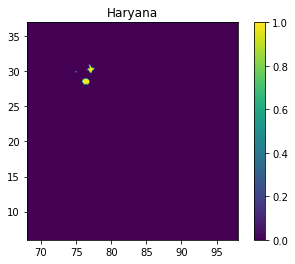

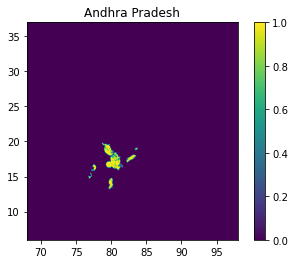

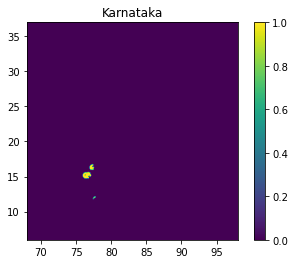

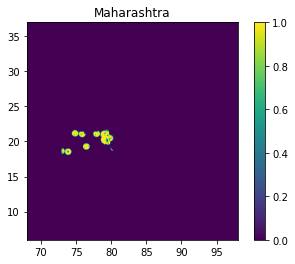

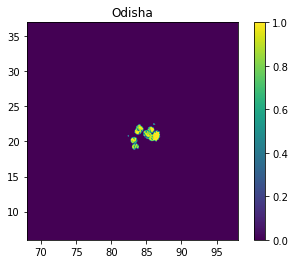

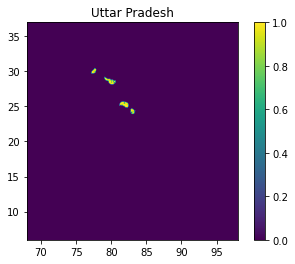

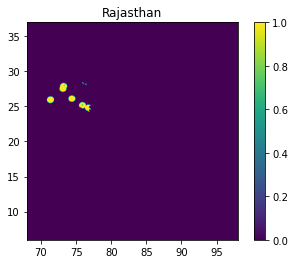

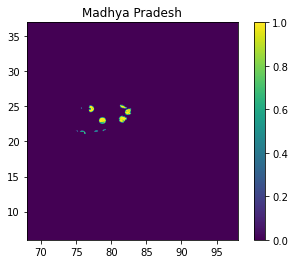

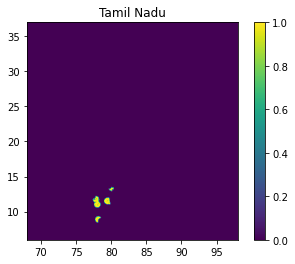

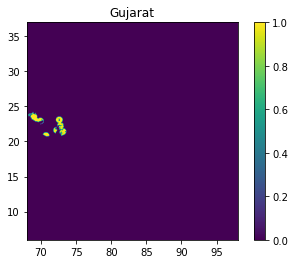

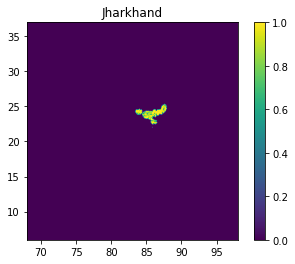

In [23]:
geodata.mask.show_all(india_wind_all.shape_mask)

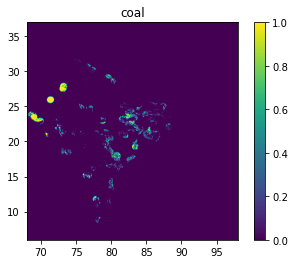

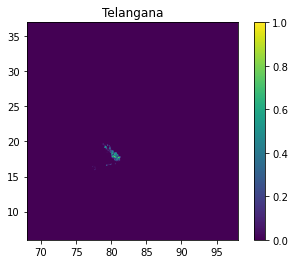

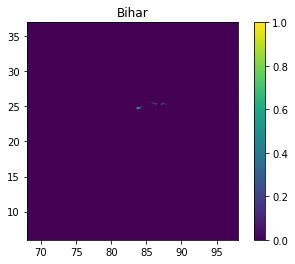

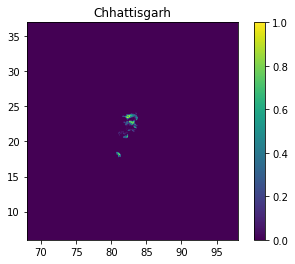

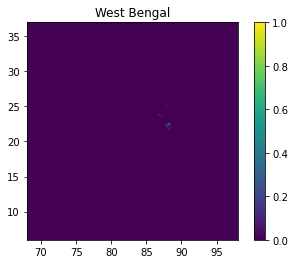

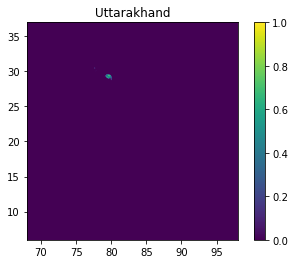

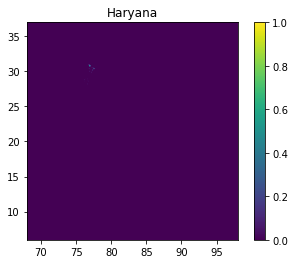

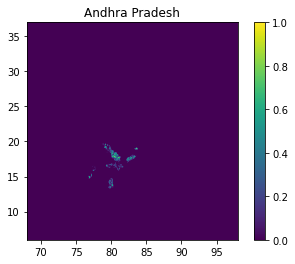

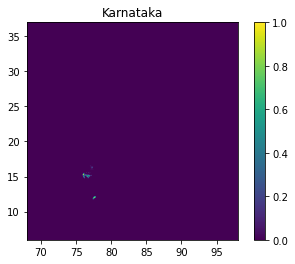

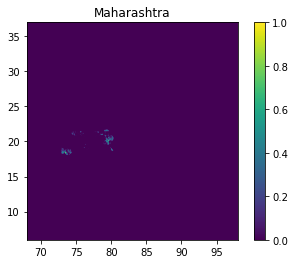

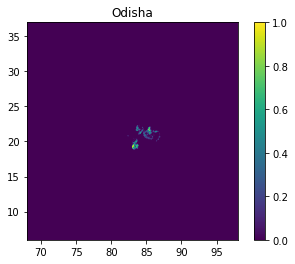

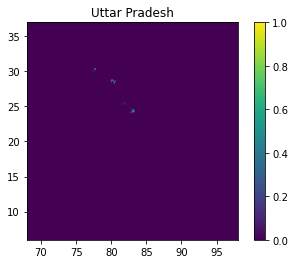

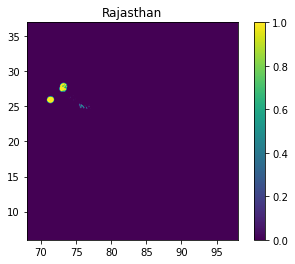

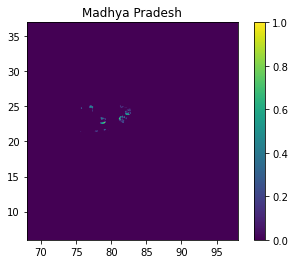

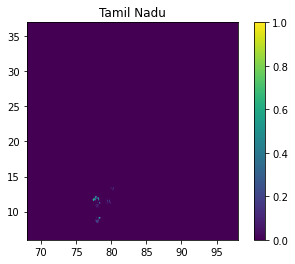

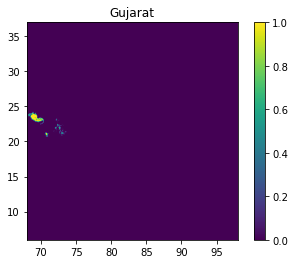

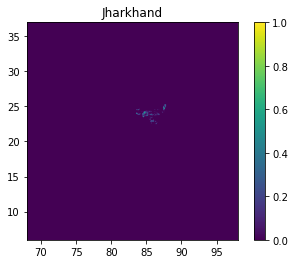

In [24]:
geodata.mask.show_all(india_solar_all.shape_mask)

# Combine Mask with Cutout

In [25]:
india_wind_plants.save_mask()
india_wind_mines.save_mask()
india_wind_all.save_mask()

india_solar_plants.save_mask()
india_solar_mines.save_mask()
india_solar_all.save_mask()

INFO:geodata.mask:Mask India Wind Plants successfully saved at C:/Users/arjun/desktop/davidson_lab/data/masks
INFO:geodata.mask:Mask India Wind Mines successfully saved at C:/Users/arjun/desktop/davidson_lab/data/masks
INFO:geodata.mask:Mask India Wind All successfully saved at C:/Users/arjun/desktop/davidson_lab/data/masks
INFO:geodata.mask:Mask India Solar Plants successfully saved at C:/Users/arjun/desktop/davidson_lab/data/masks
INFO:geodata.mask:Mask India Solar Mines successfully saved at C:/Users/arjun/desktop/davidson_lab/data/masks
INFO:geodata.mask:Mask India Solar All successfully saved at C:/Users/arjun/desktop/davidson_lab/data/masks


In [26]:
cutout.add_mask("India Wind Plants", merged_mask=False, shape_mask=True)
cutout.add_grid_area()
combine_wind_plants = cutout.mask(dataset = xarray_ds_wind)

cutout.add_mask("India Wind Mines", merged_mask=False, shape_mask=True)
cutout.add_grid_area()
combine_wind_mines = cutout.mask(dataset = xarray_ds_wind)

cutout.add_mask("India Wind All", merged_mask=False, shape_mask=True)
cutout.add_grid_area()
combine_wind_all = cutout.mask(dataset = xarray_ds_wind)


cutout.add_mask("India Solar Plants", merged_mask=False, shape_mask=True)
cutout.add_grid_area()
combine_solar_plants = cutout.mask(dataset = xarray_ds_solar)

cutout.add_mask("India Solar Mines", merged_mask=False, shape_mask=True)
cutout.add_grid_area()
combine_solar_mines = cutout.mask(dataset = xarray_ds_solar)

cutout.add_mask("India Solar All", merged_mask=False, shape_mask=True)
cutout.add_grid_area()
combine_solar_all = cutout.mask(dataset = xarray_ds_solar)

INFO:geodata.mask:Layer ['coal', 'modis'] loaded to the mask India Wind Plants.
INFO:geodata.mask:Merged_mask loaded to the mask India Wind Plants.
INFO:geodata.mask:Shape mask ['Andhra Pradesh', 'Bihar', 'Chhattisgarh', 'coal', 'Gujarat', 'Haryana', 'Jharkhand', 'Karnataka', 'Madhya Pradesh', 'Maharashtra', 'Odisha', 'Rajasthan', 'Tamil Nadu', 'Telangana', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal'] loaded to the mask India Wind Plants.
INFO:geodata.mask:Please close the shape_mask xarray(s) for further changes of the mask object.
INFO:geodata.cutout:Cutout.shape_mask added.
INFO:geodata.cutout:shape_mask combined with dataset. 
INFO:geodata.mask:Layer ['coal', 'modis'] loaded to the mask India Wind Mines.
INFO:geodata.mask:Merged_mask loaded to the mask India Wind Mines.
INFO:geodata.mask:Shape mask ['Chhattisgarh', 'coal', 'Gujarat', 'Jharkhand', 'Madhya Pradesh', 'Maharashtra', 'Odisha', 'Rajasthan', 'Tamil Nadu', 'Telangana', 'Uttar Pradesh', 'West Bengal'] loaded to the mask I

# Plot CF Supply Curves

In [27]:
def make_figures(df, col, lcoe):
    df = df[df[col] > 0]
    if col == 'wind':
        df['cap'] = df['area'] * df['mask'] * 3.9 / 1000
    else:
        df['cap'] = df['area'] * df['mask'] * 27.7 / 1000
    if lcoe:
        df = df.sort_values(by = 'LCOE ($/MWh)', ascending = True)
    else:
        df = df.sort_values(by = col, ascending = False)
    df = df[df['cap'] > 0]
    df['cumsum'] = df['cap'].cumsum()
    return df.reset_index(drop=True)

def batch_figures(xr_provs, col, coal, t_30, t_47, lcoe=False):
    dfs = {xr_prov:[] for xr_prov in xr_provs}
    for xr_prov in xr_provs:
        if xr_prov != 'coal':
            df = xr_provs[xr_prov].to_dataframe().reset_index(drop=False)
            df = make_figures(df, col, lcoe)
            dfs[xr_prov] = df
    fig = go.Figure()
    if lcoe:
        for xr_prov in xr_provs:
            if xr_prov != 'coal':
                fig.add_trace(
                    go.Scatter(
                        x=dfs[xr_prov]['cumsum'],
                        y=dfs[xr_prov]['LCOE ($/MWh)'],
                        mode='lines', 
                        name=xr_prov,
                        showlegend=True
                    )
                )
        fig.update_layout(
            title="{} LCOE Supply Curves near Coal {} in India".format(col.capitalize(), coal),
            xaxis_title="Cumulative Capacity (GW)",
            yaxis_title="LCOE ($/MWh)",
            legend_title="Provinces",
        )
    else:
        for xr_prov in xr_provs:
            if xr_prov != 'coal':
                fig.add_trace(
                    go.Scatter(
                        x=dfs[xr_prov]['cumsum'],
                        y=dfs[xr_prov][col],
                        mode='lines', 
                        name=xr_prov,
                        showlegend=True
                    )
                )      
        fig.update_layout(
            title="{} Capacity Supply Curves near Coal {} in India".format(col.capitalize(), coal),
            xaxis_title="Cumulative Capacity (GW)",
            yaxis_title="Capacity Factor (%)",
            legend_title="Provinces",
        )
    fig.add_vline(
        x=sum(t_30.values()),
        annotation_text="Target 2030: {} GW".format(round(sum(t_30.values()), 2)),
        annotation_position='bottom right',
        line_dash="dash"
    )
    fig.add_vline(
        x=sum(t_47.values()),
        annotation_text="Target 2047: {} GW".format(round(sum(t_47.values()), 2)),
        annotation_position='bottom right',
        line_dash="dash"
    )
        
    fig.show()

    return dfs

## Capacity Supply Curves

### Solar

In [29]:
plant_solar_dfs = batch_figures(combine_solar_plants, 'solar', 'Plants', solar_t_30, solar_t_47)

In [30]:
mine_solar_dfs = batch_figures(combine_solar_mines, 'solar', 'Mines', solar_t_30, solar_t_47)

In [31]:
all_solar_dfs = batch_figures(combine_solar_all, 'solar', 'Plants+Mines', solar_t_30, solar_t_47)

### Wind

In [35]:
plant_wind_dfs = batch_figures(combine_wind_plants, 'wind', 'Plants', wind_t_30, wind_t_47)

In [36]:
mine_wind_dfs = batch_figures(combine_wind_mines, 'wind', 'Mines', wind_t_30, wind_t_47)

In [37]:
all_wind_dfs = batch_figures(combine_wind_all, 'wind', 'Plants+Mines', wind_t_30, wind_t_47)

## LCOE Supply Curves

### Solar

In [38]:
plant_solar_dfs_lcoe = batch_figures(combine_solar_plants, 'solar', 'Plants', solar_t_30, solar_t_47, True)

In [39]:
mine_solar_dfs_lcoe = batch_figures(combine_solar_mines, 'solar', 'Mines', solar_t_30, solar_t_47, True)

In [40]:
all_solar_dfs_lcoe = batch_figures(combine_solar_all, 'solar', 'Plants+Mines', solar_t_30, solar_t_47, True)

### Wind

In [41]:
plant_wind_dfs_lcoe = batch_figures(combine_wind_plants, 'wind', 'Plants', wind_t_30, wind_t_47, True)

In [42]:
mine_wind_dfs_lcoe = batch_figures(combine_wind_mines, 'wind', 'Mines', wind_t_30, wind_t_47, True)

In [43]:
all_wind_dfs_lcoe = batch_figures(combine_wind_all, 'wind', 'Plants+Mines', wind_t_30, wind_t_47, True)

# Plot Figures by State

In [57]:
def plot_fig_state(restricted_dfs, col, state, level, t_30, t_47, lcoe=False):
    fig = go.Figure()
    df = restricted_dfs[state]
    df_30 = df[df['cumsum'] <= t_30[state]]
    df_47 = df[df['cumsum'] <= t_47[state]]
    avg_30 = np.nan
    avg_47 = np.nan
    if lcoe: 
        if sum(df_30['cap']) > 0 and sum(df_47['cap']) > 0:
            avg_30 = round(sum(df_30['cap'] * df_30['LCOE ($/MWh)']) / sum(df_30['cap']), 2)        
            avg_47 = round(sum(df_47['cap'] * df_47['LCOE ($/MWh)']) / sum(df_47['cap']), 2)
            fig.add_trace(
                go.Scatter(
                    x=restricted_dfs[state]['cumsum'],
                    y=restricted_dfs[state]['LCOE ($/MWh)'],
                    name='Restricted Case')
            )
            fig.add_hline(
                y=avg_30,
                annotation_text="Mean LCOE 2030: {} $/MWh".format(avg_30),
                annotation_position='bottom left',
                line_dash="dash"
            )
            fig.add_hline(
                y=avg_47,
                annotation_text="Mean LCOE 2047: {} $/MWh".format(avg_47),
                annotation_position='top left',
                line_dash="dash"
            )
            fig.update_layout(
                title="{} LCOE Supply Curves in Provinces with Coal {} in {}".format(col.capitalize(), level, state),
                xaxis_title="Cumulative Capacity (GW)",
                yaxis_title="LCOE ($/MWh)",
                legend_title="Province",
            )
            if col == 'wind':
                fig.update_yaxes(
                    range=(40, 80)
                )
    else:
        if sum(df_30['cap']) > 0 and sum(df_47['cap']) > 0:
            avg_30 = round(sum(df_30['cap'] * df_30[col]) / sum(df_30['cap']), 4)        
            avg_47 = round(sum(df_47['cap'] * df_47[col]) / sum(df_47['cap']), 4)

            fig.add_trace(
                go.Scatter(
                    x=restricted_dfs[state]['cumsum'],
                    y=restricted_dfs[state][col], 
                    name='Restricted Case')
            )
            fig.add_hline(
                y=avg_30,
                annotation_text="Mean CF 2030: {}".format(avg_30),
                annotation_position='top left',
                line_dash="dash"
            )
            fig.add_hline(
                y=avg_47,
                annotation_text="Mean CF 2047: {}".format(avg_47),
                annotation_position='bottom left',
                line_dash="dash"
            )
            fig.update_layout(
                title="{} Capacity Supply Curves in Provinces with Coal {} in {}".format(col.capitalize(), level, state),            
                xaxis_title="Cumulative Capacity (GW)",
                yaxis_title="Capacity Factor (%)",
                legend_title="Province",
            )
    fig.add_vline(
        x=t_30[state],
        annotation_text="Target 2030: {} GW".format(round(t_30[state], 2)),
        annotation_position='bottom right',
        line_dash="dash"
    )
    fig.add_vline(
        x=t_47[state],
        annotation_text="Target 2047: {} GW".format(round(t_47[state], 2)),
        annotation_position='bottom right',
        line_dash="dash"
    )
    if len(restricted_dfs[state]['cumsum']) > 0:
        fig.update_xaxes(
            range=(restricted_dfs[state]['cumsum'][0], 55)
        )
    fig.show()
    return round(avg_30, 2), round(avg_47, 2)

## Capacity Supply Curves

### Solar

In [58]:
plot_fig_state(plant_solar_dfs, 'solar', 'Gujarat', 'Plants', solar_t_30, solar_t_47)

(0.21, 0.21)

In [59]:
plot_fig_state(mine_solar_dfs, 'solar', 'Gujarat', 'Mines', solar_t_30, solar_t_47)

(0.21, 0.21)

In [60]:
plot_fig_state(all_solar_dfs, 'solar', 'Gujarat', 'Plants+Mines', solar_t_30, solar_t_47)

(0.21, 0.21)

### Wind

In [61]:
plot_fig_state(plant_wind_dfs, 'wind', 'Gujarat', 'Plants', wind_t_30, wind_t_47)

(0.35, 0.33)

In [62]:
plot_fig_state(mine_wind_dfs, 'wind', 'Gujarat', 'Mines', wind_t_30, wind_t_47)

(0.34, 0.29)

In [63]:
plot_fig_state(all_wind_dfs, 'wind', 'Gujarat', 'Plants+Mines', wind_t_30, wind_t_47)

(0.35, 0.33)

## LCOE Supply Curves

### Solar

In [64]:
plot_fig_state(plant_solar_dfs_lcoe, 'solar', 'Gujarat', 'Plants', solar_t_30, solar_t_47, True)

(nan, nan)

In [65]:
plot_fig_state(mine_solar_dfs_lcoe, 'solar', 'Gujarat', 'Mines', solar_t_30, solar_t_47, True)

(51.43, 51.56)

In [66]:
plot_fig_state(all_solar_dfs_lcoe, 'solar', 'Gujarat', 'Plants+Mines', solar_t_30, solar_t_47, True)

(nan, nan)

### Wind

In [67]:
plot_fig_state(plant_wind_dfs_lcoe, 'wind', 'Gujarat', 'Plants', wind_t_30, wind_t_47, True)

(47.63, 50.91)

In [68]:
plot_fig_state(mine_wind_dfs_lcoe, 'wind', 'Gujarat', 'Mines', wind_t_30, wind_t_47, True)

(49.24, 61.28)

In [69]:
plot_fig_state(all_wind_dfs_lcoe, 'wind', 'Gujarat', 'Plants+Mines', wind_t_30, wind_t_47, True)

(47.63, 50.36)

# Get State Averages

In [77]:
plants

Plant           State     Status  \
6744          Adani Korba West power station    Chhattisgarh  operating   
6748          Aditya Aluminium power station          Odisha  operating   
6756                     Ajmer power station       Rajasthan  operating   
6758                  Akrimota Power Project         Gujarat  operating   
6764  Ambujanagar Cement Plant power station         Gujarat  operating   
...                                      ...             ...        ...   
8574            Vizag Simhadri power station  Andhra Pradesh  operating   
8575         Vizag Steel Plant power station  Andhra Pradesh  operating   
8580               Vizag Thermal Power Plant  Andhra Pradesh  operating   
8597              Wardha Works power station     Maharashtra  operating   
8622                  Yermarus power station       Karnataka  operating   

       Latitude  Longitude  Capacity (MW)  \
6744  21.743775  83.274093          600.0   
6748  21.740068  84.060592          150.0   
6756  26.073889  74.385000          150.0   
6758  23.772500  68.645556          125.0   
6764  20.835455  70.695539           30.0   
...         ...        ...            ...   
8574  17.636926  83.193133           50.0   
8575  17.606547  83.196713           60.0   
8580  17.563643  83.138877          520.0   
8597  20.460000  79.800000           40.0   
8622  16.295261  77.356120          800.0   

      Annual CO2 (million tonnes / annum)  Plant Age  \
6744                                  3.0        7.0   
6748                                  0.7        7.0   
6756                                  0.7       10.0   
6758                                  1.2       14.0   
6764                                  0.2       14.0   
...                                   ...        ...   
8574                                  0.2        9.0   
8575                                  0.3       32.0   
8580                                  2.0        6.0   
8597                                  0.2       22.0   
8622                                  3.0        5.0   

                                               geometry  
6744  POLYGON ((83.75743220664062 21.74306951038144,...  
6748  POLYGON ((84.54391860776425 21.73936244263258,...  
6756  POLYGON ((74.88472270202699 26.07302396029403,...  
6758  POLYGON ((69.13608709913443 23.77172079770842,...  
6764  POLYGON ((71.17591966813633 20.83478131957076,...  
...                                                 ...  
8574  POLYGON ((83.66429843374601 17.63636349981647,...  
8575  POLYGON ((83.6677997740656 17.60598503081499, ...  
8580  POLYGON ((83.6098527717525 17.56308218629981, ...  
8597  POLYGON ((80.27920241525854 20.45933982240146,...  
8622  POLYGON ((77.82395229033339 16.2947438220374, ...  

[117 rows x 9 columns]

In [111]:
states = set(np.unique(mines['State, Province'])).intersection(set(np.unique(plants['State'])))

In [112]:
averages_2030 = {state: [] for state in states if solar_t_30[state] > 0 or wind_t_30[state] > 0}
averages_2047 = {state: [] for state in states if solar_t_47[state] > 0 or wind_t_47[state] > 0}

for state in states:
    wind_all_avg_CF = plot_fig_state(all_wind_dfs, 'wind', state, 'Plants+Mines', wind_t_30, wind_t_47)
    wind_all_avg_LCOE = plot_fig_state(all_wind_dfs_lcoe, 'wind', state, 'Plants+Mines', wind_t_30, wind_t_47, True)
    solar_all_avg_CF = plot_fig_state(all_solar_dfs, 'solar', state, 'Plants+Mines', solar_t_30, solar_t_47)
    solar_all_avg_LCOE = plot_fig_state(all_solar_dfs_lcoe, 'solar', state, 'Plants+Mines', solar_t_30, solar_t_47, True)

    averages_2030[state] = [wind_all_avg_CF[0], wind_all_avg_LCOE[0], solar_all_avg_CF[0], solar_all_avg_LCOE[0]]
    averages_2047[state] = [wind_all_avg_CF[1], wind_all_avg_LCOE[1], solar_all_avg_CF[1], solar_all_avg_LCOE[1]]

In [103]:
# make pivot tables
pivot_2030 = pd.DataFrame(averages_2030).T
pivot_2030.columns = ['wind_all_avg_CF', 'wind_all_avg_LCOE', 'solar_all_avg_CF', 'solar_all_avg_LCOE']

pivot_2047 = pd.DataFrame(averages_2047).T
pivot_2047.columns = ['wind_all_avg_CF', 'wind_all_avg_LCOE', 'solar_all_avg_CF', 'solar_all_avg_LCOE']

In [104]:
# # break down into smaller dataframes
cf_summary_30 = pivot_2030[['wind_all_avg_CF', 'solar_all_avg_CF']]
cf_summary_30.columns = ['Wind', 'Solar']
lcoe_summary_30 = pivot_2030[['wind_all_avg_LCOE', 'solar_all_avg_LCOE']]
lcoe_summary_30.columns = ['Wind', 'Solar']

cf_summary_47 = pivot_2047[['wind_all_avg_CF', 'solar_all_avg_CF']]
cf_summary_47.columns = ['Wind', 'Solar']
lcoe_summary_47 = pivot_2047[['wind_all_avg_LCOE', 'solar_all_avg_LCOE']]
lcoe_summary_47.columns = ['Wind', 'Solar']

Text(0.5, 1.0, 'Average State CFs for Wind and Solar in 2030')

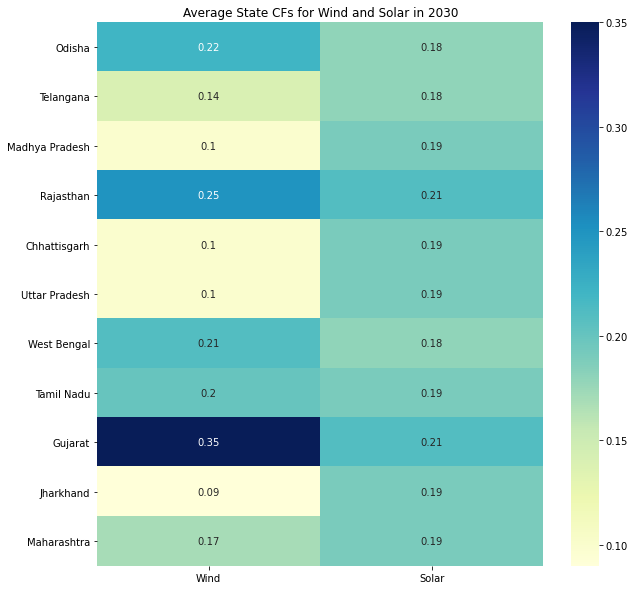

In [105]:
# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))         
ax = sns.heatmap(cf_summary_30, annot=True, fmt=".4", cmap="YlGnBu")
plt.title("Average State CFs for Wind and Solar in 2030")

Text(0.5, 1.0, 'Average State LCOE ($/MWh) for Wind and Solar in 2030')

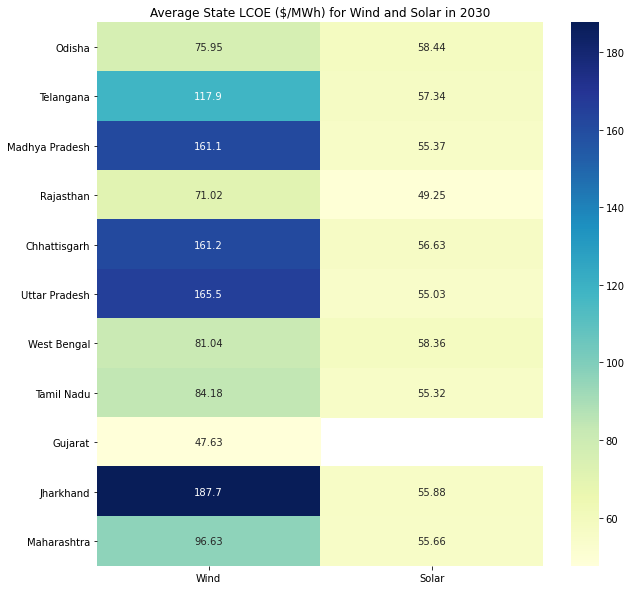

In [106]:
# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))         
ax = sns.heatmap(lcoe_summary_30, annot=True, fmt=".4", cmap="YlGnBu")
plt.title("Average State LCOE ($/MWh) for Wind and Solar in 2030")

Text(0.5, 1.0, 'Average State CFs for Wind and Solar in 2047')

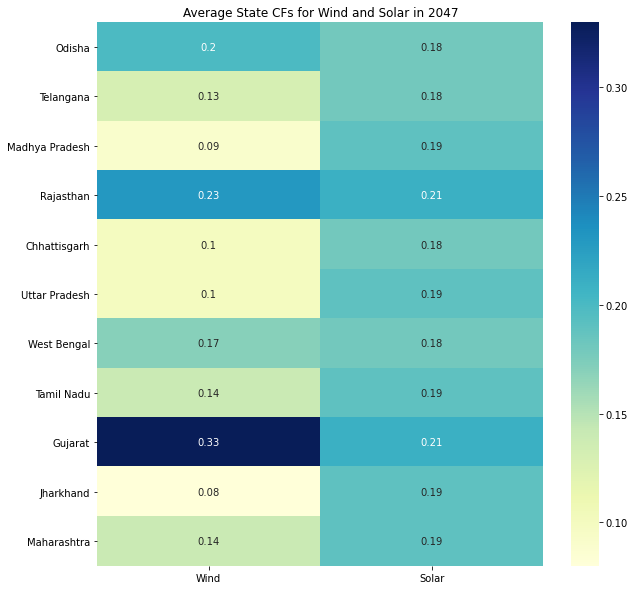

In [107]:
# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))         
ax = sns.heatmap(cf_summary_47, annot=True, fmt=".4", cmap="YlGnBu")
plt.title("Average State CFs for Wind and Solar in 2047")

Text(0.5, 1.0, 'Average State LCOE ($/MWh) for Wind and Solar in 2047')

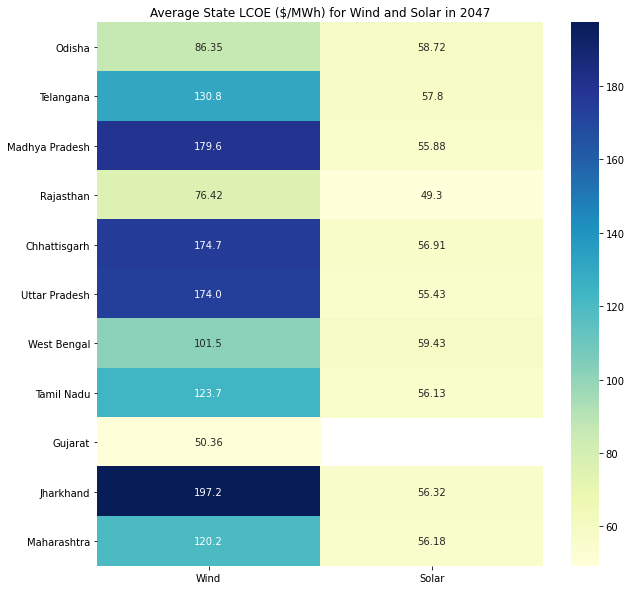

In [108]:
# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))         
ax = sns.heatmap(lcoe_summary_47, annot=True, fmt=".4", cmap="YlGnBu")
plt.title("Average State LCOE ($/MWh) for Wind and Solar in 2047")